In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import optuna


In [43]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


In [44]:
df = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")

In [45]:
df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
651,652,15813850,Christian,720,France,Male,52.0,7,0.00,1,1.0,1.0,14781.12,0
4324,4325,15577970,Alexeeva,489,France,Male,34.0,5,0.00,1,0.0,0.0,43540.59,0
9385,9386,15759244,Boone,687,Germany,Male,44.0,8,95368.14,2,1.0,1.0,1787.85,0
6737,6738,15706223,Barnes,715,Spain,Male,38.0,2,96798.79,2,1.0,1.0,4554.67,0
2863,2864,15659175,Severson,755,France,Female,43.0,9,0.00,2,1.0,0.0,18066.69,0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


In [47]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [48]:
df.shape

(10002, 14)

In [49]:
df.dropna(inplace=True)

In [50]:
df.shape

(9998, 14)

In [51]:
df.duplicated().sum()

2

In [52]:
df.drop_duplicates(keep='first', inplace=True)

In [53]:
df.shape

(9996, 14)

In [54]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [55]:
df = df.drop(['RowNumber','CustomerId', 'Surname'], axis=1)

In [56]:
df['IsActiveMember'] = df['IsActiveMember'].astype(int)
df['HasCrCard'] = df['HasCrCard'].astype(int)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9996 entries, 0 to 10000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9996 non-null   int64  
 1   Geography        9996 non-null   object 
 2   Gender           9996 non-null   object 
 3   Age              9996 non-null   float64
 4   Tenure           9996 non-null   int64  
 5   Balance          9996 non-null   float64
 6   NumOfProducts    9996 non-null   int64  
 7   HasCrCard        9996 non-null   int64  
 8   IsActiveMember   9996 non-null   int64  
 9   EstimatedSalary  9996 non-null   float64
 10  Exited           9996 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 937.1+ KB


In [58]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000
mean,650.503301,38.921071,5.013305,76476.263216,1.530212,0.705482,0.514906,100106.701248,0.203782
std,96.624668,10.488421,2.892353,62397.118820,0.581684,0.455849,0.499803,57513.314398,0.402829
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97173.290000,1.000000,1.000000,1.000000,100238.110000,0.000000
75%,717.250000,44.000000,7.250000,127639.372500,2.000000,1.000000,1.000000,149400.107500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [59]:
df['Exited'].value_counts()

Exited
0    7959
1    2037
Name: count, dtype: int64

In [60]:
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

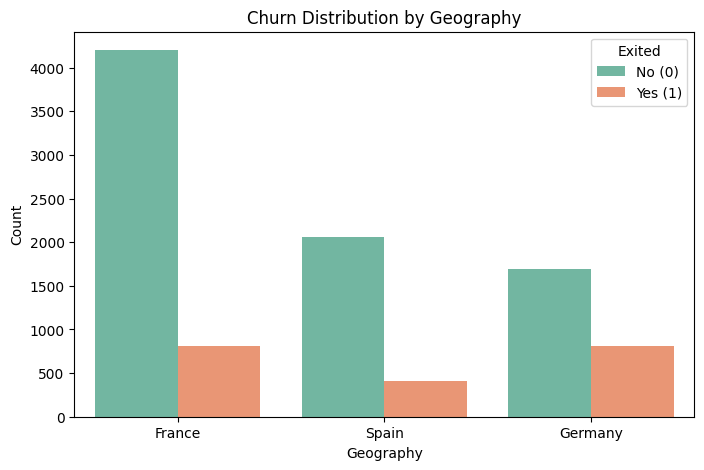

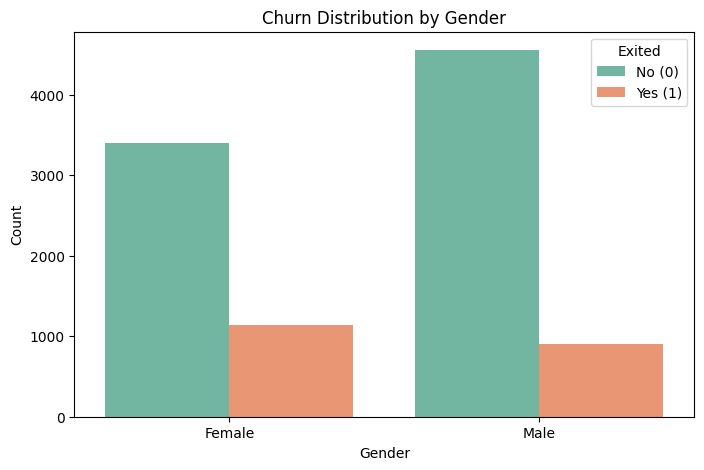

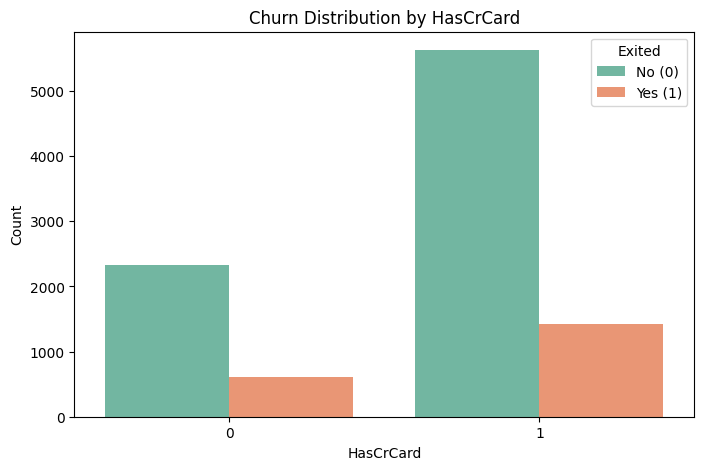

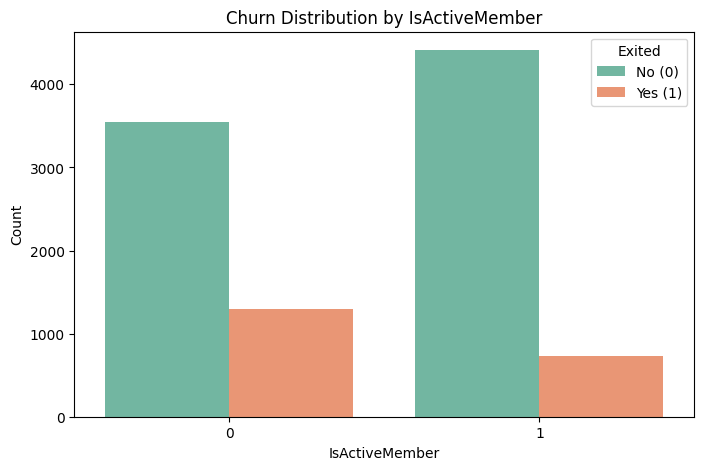

In [61]:
for col in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=col, hue='Exited', data=df, palette='Set2')
    plt.title(f"Churn Distribution by {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title="Exited", labels=["No (0)", "Yes (1)"])
    plt.show()

In [62]:
X = df.drop(columns=['Exited'], axis=1)
y = df['Exited']

In [63]:
X.shape, y.shape

((9996, 10), (9996,))

In [64]:
num_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

cat_pipeline = Pipeline(steps=[
    ('one_hot_enc', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [65]:
cat_columns = ['Gender','Geography']

In [66]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, numerical_features),
    ('cat_pipeline', cat_pipeline, cat_columns),
    ],remainder='passthrough',
    n_jobs=-1
)

In [67]:
X = col_trans.fit_transform(X)

In [68]:
X.shape

(9996, 11)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
X_train.shape, X_test.shape

((7996, 11), (2000, 11))

In [88]:
# Define the objective function for Optuna
def objective(trial):
    # Choose the algorithm to tune
    classifier_name = trial.suggest_categorical('classifier', ['SVM', 'RandomForest', 'GradientBoosting'])

    if classifier_name == 'SVM':
        # SVM hyperparameters
        c = trial.suggest_float('C', 0.1, 100, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

        model = SVC(C=c, kernel=kernel, gamma=gamma, random_state=42)

    elif classifier_name == 'RandomForest':
        # Random Forest hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            random_state=42
        )

    elif classifier_name == 'GradientBoosting':
        # Gradient Boosting hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

    # Perform cross-validation and return the mean accuracy
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

In [89]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-01-28 15:36:18,010] A new study created in memory with name: no-name-3616a683-3cb1-4c98-83b1-6be5b6e0c05a
[I 2025-01-28 15:36:20,315] Trial 0 finished with value: 0.8176586829634238 and parameters: {'classifier': 'SVM', 'C': 0.10946408750880736, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.8176586829634238.
[I 2025-01-28 15:36:31,940] Trial 1 finished with value: 0.8520508644984885 and parameters: {'classifier': 'GradientBoosting', 'n_estimators': 84, 'learning_rate': 0.045645310840946016, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8520508644984885.
[I 2025-01-28 15:37:02,289] Trial 2 finished with value: 0.8543018024675023 and parameters: {'classifier': 'GradientBoosting', 'n_estimators': 215, 'learning_rate': 0.026242990783939834, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8543018024675023.
[I 2025-01-28 15:37:05,948] Trial 3 finished with value: 0.698

In [90]:
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

Best trial accuracy: 0.8660573680005368
Best hyperparameters: {'classifier': 'RandomForest', 'n_estimators': 149, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': False}


In [91]:
best_params = {'n_estimators': 149, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': False}

In [93]:
best_model = RandomForestClassifier(**best_params, random_state=42)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)

print(f'Test Accuracy with best hyperparameters: {test_accuracy:.2f}')

Test Accuracy with best hyperparameters: 0.86


In [71]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [72]:
X_train_smote.shape, y_train_smote.shape

((12736, 11), (12736,))

In [73]:
y_train_smote.value_counts()

Exited
0    6368
1    6368
Name: count, dtype: int64

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1591
           1       0.63      0.62      0.62       409

    accuracy                           0.85      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.85      0.85      0.85      2000



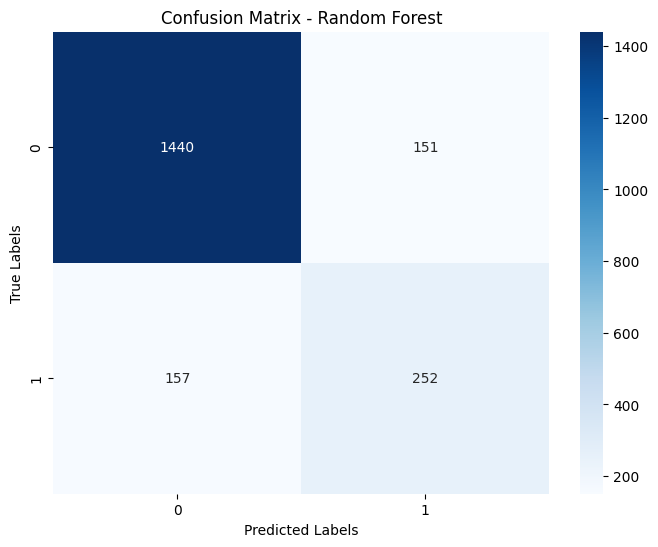

In [74]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1591
           1       0.60      0.66      0.63       409

    accuracy                           0.84      2000
   macro avg       0.75      0.77      0.76      2000
weighted avg       0.85      0.84      0.84      2000



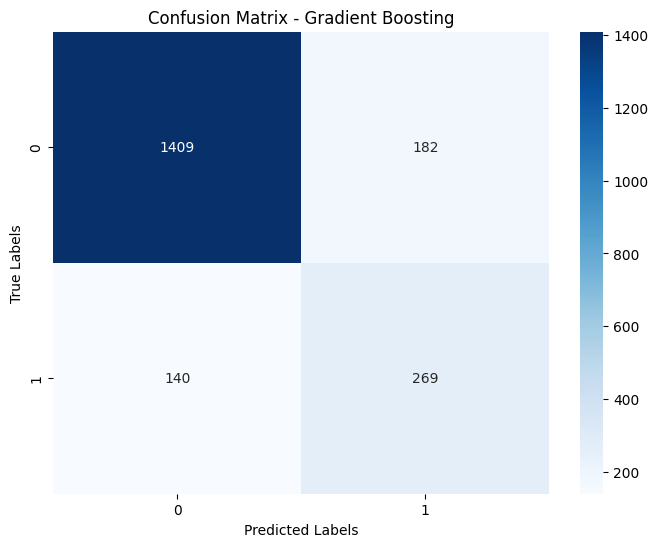

In [75]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_smote, y_train_smote)

y_pred = gb.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1591
           1       0.49      0.71      0.58       409

    accuracy                           0.79      2000
   macro avg       0.70      0.76      0.72      2000
weighted avg       0.83      0.79      0.80      2000



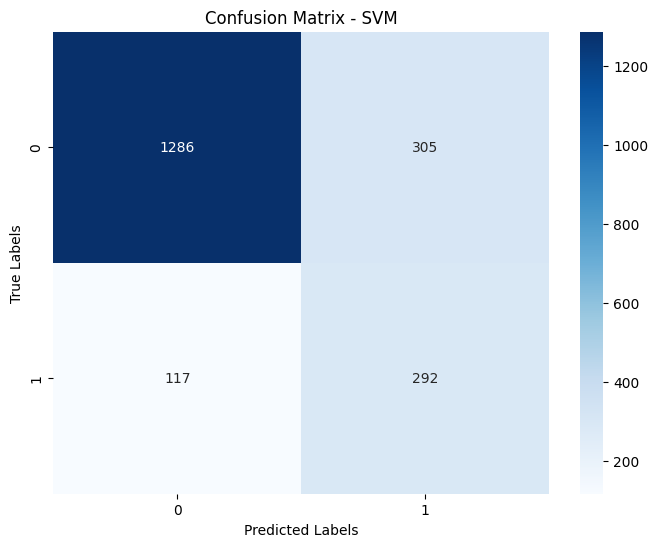

In [76]:
svm = SVC(random_state=42)
svm.fit(X_train_smote, y_train_smote)

y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [77]:
# Define the objective function for Optuna
def objective(trial):
    # Choose the algorithm to tune
    classifier_name = trial.suggest_categorical('classifier', ['SVM', 'RandomForest', 'GradientBoosting'])

    if classifier_name == 'SVM':
        # SVM hyperparameters
        c = trial.suggest_float('C', 0.1, 100, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

        model = SVC(C=c, kernel=kernel, gamma=gamma, random_state=42)

    elif classifier_name == 'RandomForest':
        # Random Forest hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            random_state=42
        )

    elif classifier_name == 'GradientBoosting':
        # Gradient Boosting hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

    # Perform cross-validation and return the mean accuracy
    score = cross_val_score(model, X_train_smote, y_train_smote, cv=3, scoring='accuracy').mean()
    return score

In [78]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-01-28 15:11:13,850] A new study created in memory with name: no-name-a7151276-c92a-476a-9d58-afbf5446360d
[I 2025-01-28 15:11:28,931] Trial 0 finished with value: 0.54640415395464 and parameters: {'classifier': 'SVM', 'C': 0.3148319378984938, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with value: 0.54640415395464.
[I 2025-01-28 15:11:38,763] Trial 1 finished with value: 0.7186717316891796 and parameters: {'classifier': 'SVM', 'C': 1.3982185220439125, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 1 with value: 0.7186717316891796.
[I 2025-01-28 15:11:41,576] Trial 2 finished with value: 0.8264006808597518 and parameters: {'classifier': 'RandomForest', 'n_estimators': 85, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 2 with value: 0.8264006808597518.
[I 2025-01-28 15:11:55,820] Trial 3 finished with value: 0.7841551789152441 and parameters: {'classifier': 'SVM', 'C': 3.062429615686892, 'kernel': 'poly', 'gamma

In [79]:
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

Best trial accuracy: 0.8989513028821694
Best hyperparameters: {'classifier': 'RandomForest', 'n_estimators': 169, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}


In [82]:
best_params = {'n_estimators': 169, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}

In [83]:
best_model = RandomForestClassifier(**best_params, random_state=42)

best_model.fit(X_train_smote, y_train_smote)

y_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)

print(f'Test Accuracy with best hyperparameters: {test_accuracy:.2f}')

Test Accuracy with best hyperparameters: 0.85
